In [1]:
import random 
import numpy as np 
import torch 
from utilities.pg_utils import set_seed
set_seed(111)

In [2]:
# The purpose of this file is to create a price tensor for input into the neural network
# and to train the policy using Deep Deterministic Policy Gradient.
# Code is inspired by the paper "A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem"
# For more details, see: c.f https://arxiv.org/abs/1706.10059


from typing import List
import torch 
from ddpgportfolio.agent.ddpg_agent import DDPGAgent
from ddpgportfolio.dataset import KrakenDataSet
from ddpgportfolio.portfolio.portfolio import Portfolio

torch.set_default_device("mps")



BATCH_SIZE = 50  # training is done in mini-batches
WINDOW_SIZE = 50  # last n timesteps for the price tensor
STEP_SIZE = 1  # for rolling window batch sampler
start_date = "2024-01-01"  # start date of trading
end_date = "2024-07-30"
N_EPISODES = 150  # number of episodes to train the agent
N_ITERATIONS_PER_EPISODE = 20
# DEVICE = "mps"

asset_names: List[str] = [
    "CASH",
    "SOL",
    "ADA",
    "USDT",
    "AVAX",
    "LINK",
    "DOT",
    "PEPE",
    "ETH",
    "XRP",
    "TRX",
    "MATIC",
]

portfolio = Portfolio(asset_names=asset_names, start_date=start_date, end_date=end_date)
# kraken_ds = KrakenDataSet(portfolio, WINDOW_SIZE)
agent = DDPGAgent(portfolio, BATCH_SIZE, WINDOW_SIZE, STEP_SIZE, 100)

# need to pretrain the agent to populate the replay buffer with experiences
agent.pre_train()
# train the agent


pre-training ddpg agent started...
ReplayMemoryBuffer populating with experience...
pretraining done
buffer size: 10097


In [3]:
portfolio.n_samples - 50

10097

In [4]:
close_pr = portfolio.get_close_price()
close_pr.shape

(10147, 12)

In [5]:

dataset = KrakenDataSet(portfolio, 50, 1)
len(dataset)


10098

In [6]:
for idx in range(len(dataset)):
    try:
        xt, end_idx = dataset[idx]
        end_idx += 2
        print(f"Sample {idx}: Start={idx * dataset.step_size}, End={end_idx}")
    except IndexError as e:
        print(f"Error at index {idx}: {e}")

Sample 0: Start=0, End=50
Sample 1: Start=1, End=51
Sample 2: Start=2, End=52
Sample 3: Start=3, End=53
Sample 4: Start=4, End=54
Sample 5: Start=5, End=55
Sample 6: Start=6, End=56
Sample 7: Start=7, End=57
Sample 8: Start=8, End=58
Sample 9: Start=9, End=59
Sample 10: Start=10, End=60
Sample 11: Start=11, End=61
Sample 12: Start=12, End=62
Sample 13: Start=13, End=63
Sample 14: Start=14, End=64
Sample 15: Start=15, End=65
Sample 16: Start=16, End=66
Sample 17: Start=17, End=67
Sample 18: Start=18, End=68
Sample 19: Start=19, End=69
Sample 20: Start=20, End=70
Sample 21: Start=21, End=71
Sample 22: Start=22, End=72
Sample 23: Start=23, End=73
Sample 24: Start=24, End=74
Sample 25: Start=25, End=75
Sample 26: Start=26, End=76
Sample 27: Start=27, End=77
Sample 28: Start=28, End=78
Sample 29: Start=29, End=79
Sample 30: Start=30, End=80
Sample 31: Start=31, End=81
Sample 32: Start=32, End=82
Sample 33: Start=33, End=83
Sample 34: Start=34, End=84
Sample 35: Start=35, End=85
Sample 36: S

In [7]:
len(close_pr)

10147

In [8]:
def calculate_total_return(equity_curve):
    """
    Calculate the total return from an equity curve.

    Args:
        equity_curve (list): List of portfolio values over time.

    Returns:
        float: Total return as a percentage.
    """
    V_start = equity_curve[0]
    V_end = equity_curve[-1]
    total_return = ((V_end - V_start) / V_start) * 100
    return total_return

In [9]:
calculate_total_return()

TypeError: calculate_total_return() missing 1 required positional argument: 'equity_curve'

In [10]:

import numpy as np
import matplotlib.pyplot as plt
weights = []
ds = KrakenDataSet(portfolio, 50, 1)


Training Started for DDPG Agent
Episode 1 - Actor Loss: 0.0718, Critic Loss: 0.6548, Total Reward: 0.4522
Episode 2 - Actor Loss: 0.0677, Critic Loss: 0.6664, Total Reward: 0.4440
Episode 3 - Actor Loss: 0.0651, Critic Loss: 0.6641, Total Reward: -0.7231
Episode 4 - Actor Loss: 0.0613, Critic Loss: 0.7016, Total Reward: 0.9181
Episode 5 - Actor Loss: 0.0643, Critic Loss: 0.6999, Total Reward: 0.4649
Episode 6 - Actor Loss: 0.0626, Critic Loss: 0.7158, Total Reward: -0.4641
Episode 7 - Actor Loss: 0.0642, Critic Loss: 0.7009, Total Reward: -1.2310
Episode 8 - Actor Loss: 0.0627, Critic Loss: 0.7314, Total Reward: 0.8421
Episode 9 - Actor Loss: 0.0587, Critic Loss: 0.7345, Total Reward: -0.0394
Episode 10 - Actor Loss: 0.0603, Critic Loss: 0.7435, Total Reward: -0.3891
Episode 11 - Actor Loss: 0.0598, Critic Loss: 0.7533, Total Reward: 0.6459
Episode 12 - Actor Loss: 0.0616, Critic Loss: 0.7748, Total Reward: 0.2317
Episode 13 - Actor Loss: 0.0603, Critic Loss: 0.7819, Total Reward: 0.61

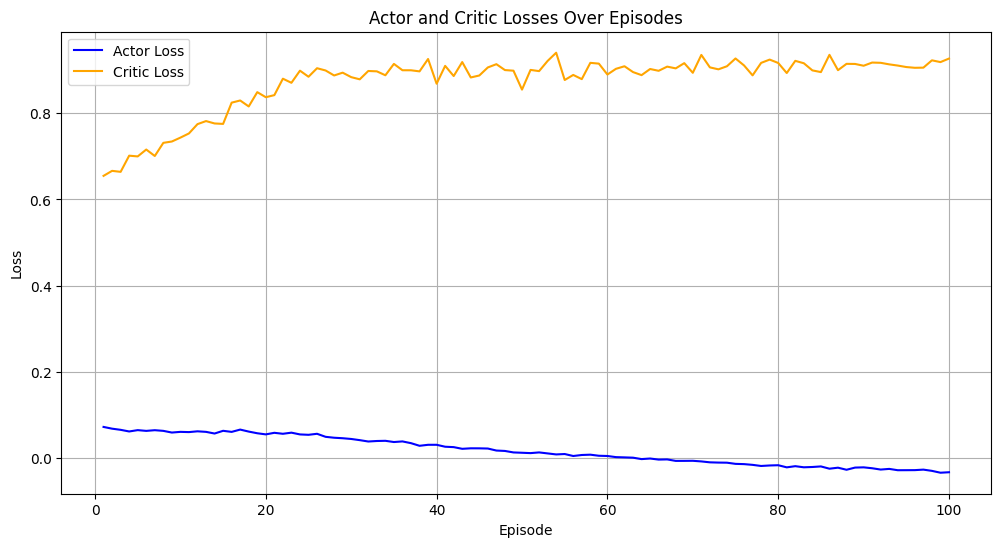

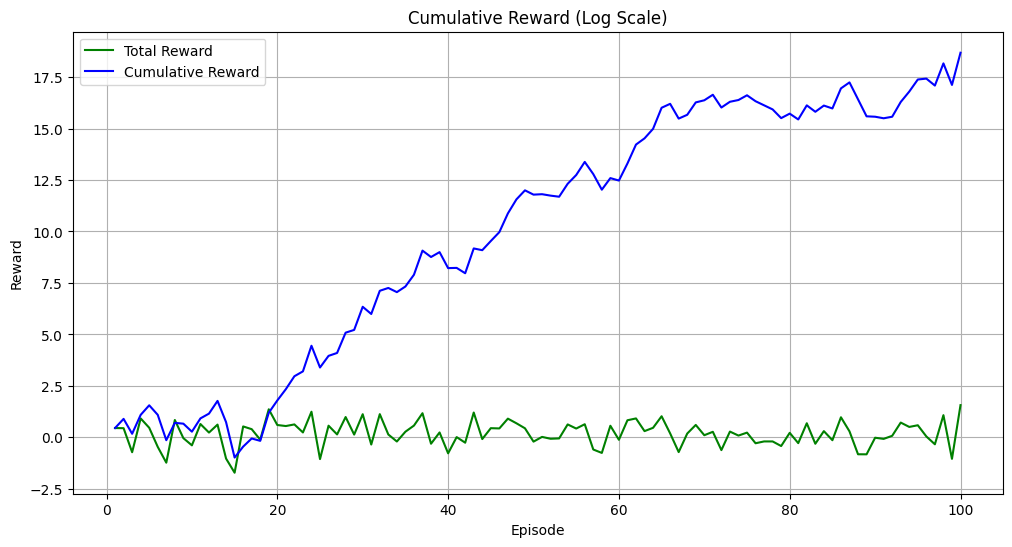

In [11]:
# train agent
agent.train(100);

In [14]:
len(agent_equity_curve)

10099

In [12]:
# checking pvm as it should be similar to buy and hold prior to training
import numpy as np
import matplotlib.pyplot as plt
weights = []
ds = KrakenDataSet(portfolio, 50, 1)
cl_price = portfolio.get_close_price()
dates = cl_price.index


pf_previous = 10000
agent_equity_curve = [pf_previous]
total_reward = 0
weights = []

for i in range(len(ds)):
    Xt, prev_index = ds[i]
    yt = 1 / Xt[0, :, -2]
    yt = torch.concat([torch.ones(1), yt], dim=-1)
    wt = agent.pvm.get_memory_stack(prev_index + 1)
    wt_cash = 1 - wt.sum()
    wt = torch.concat([wt_cash.unsqueeze(0), wt], dim=-1)
    weights.append(wt)
    reward = torch.dot(wt, yt) 
    pf_current = pf_previous * reward
    agent_equity_curve.append(pf_current.item())
    pf_previous = pf_current


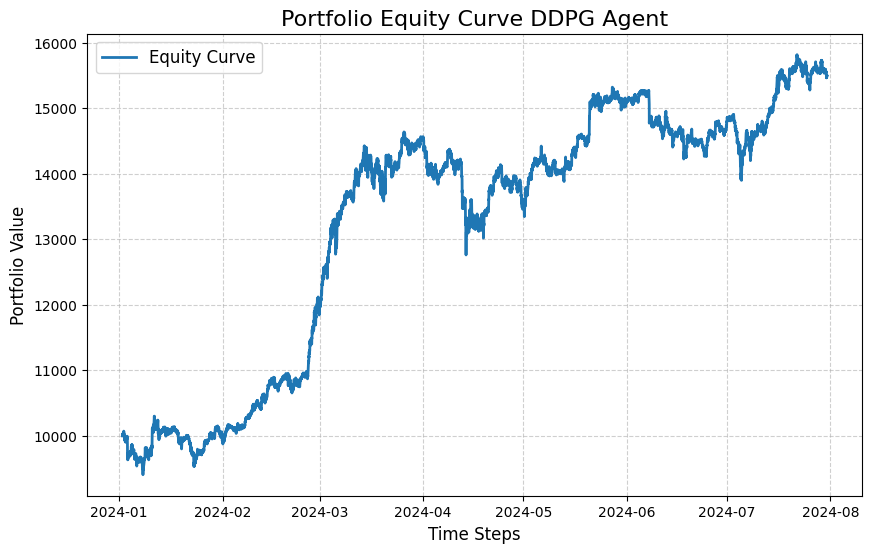

In [13]:
# Plot the equity curve
plt.figure(figsize=(10, 6))
plt.plot(dates[48:], agent_equity_curve, label="Equity Curve", linewidth=2)
plt.title("Portfolio Equity Curve DDPG Agent", fontsize=16)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Portfolio Value", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.show()

In [18]:
len(ds)

10098

In [14]:
calculate_total_return(agent_equity_curve)

54.9216796875

In [9]:
calculate_total_return(agent_equity_curve)

73.18025390625

In [ ]:
portfolio.asset_names

In [15]:
weights[-5:]

[tensor([0.6235, 0.0346, 0.0353, 0.0360, 0.0334, 0.0331, 0.0329, 0.0320, 0.0343,
         0.0382, 0.0338, 0.0329], device='mps:0'),
 tensor([0.6296, 0.0339, 0.0347, 0.0353, 0.0329, 0.0324, 0.0323, 0.0318, 0.0336,
         0.0375, 0.0335, 0.0327], device='mps:0'),
 tensor([0.6305, 0.0338, 0.0349, 0.0352, 0.0329, 0.0321, 0.0322, 0.0317, 0.0333,
         0.0370, 0.0336, 0.0327], device='mps:0'),
 tensor([0.6284, 0.0341, 0.0349, 0.0357, 0.0333, 0.0326, 0.0325, 0.0320, 0.0335,
         0.0360, 0.0343, 0.0327], device='mps:0'),
 tensor([0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833,
         0.0833, 0.0833, 0.0833], device='mps:0')]

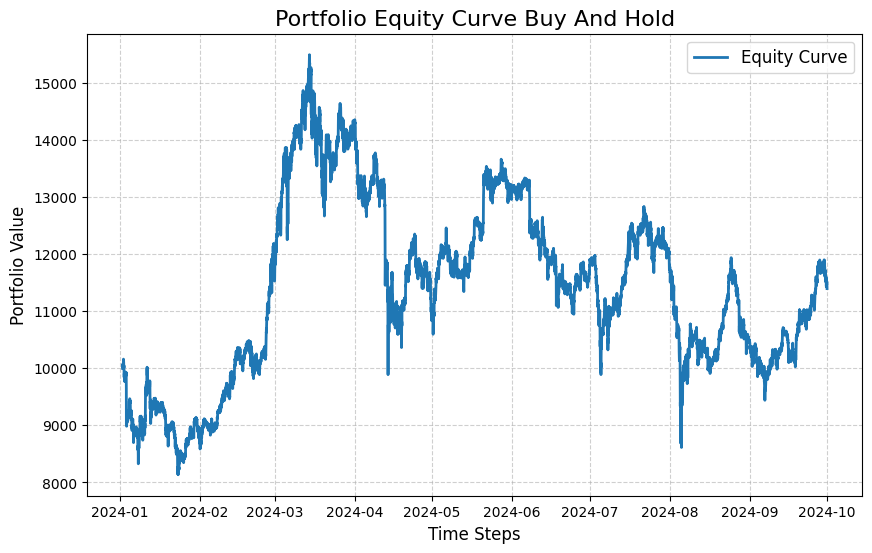

In [37]:
# buy and hold
buy_and_hold_weights = np.ones(12) / 12 # Equal allocation
buy_and_hold_equity = [10000]
pf_previous = 10000

for i in range(len(ds) + 48):
    Xt, _ = ds[i]
    yt = 1 / Xt[0, :, -2] # Price relatives
    yt = torch.concat([torch.ones(1), yt], dim=-1)
    reward = np.dot(buy_and_hold_weights, yt.cpu().numpy())  # No rebalancing
    pf_current = pf_previous * reward
    buy_and_hold_equity.append(pf_current)
    pf_previous = pf_current

cl_price = portfolio.get_close_price()
dates = cl_price.index
plt.figure(figsize=(10, 6))
plt.plot(dates[50:], buy_and_hold_equity, label="Equity Curve", linewidth=2)
plt.title("Portfolio Equity Curve Buy And Hold", fontsize=16)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Portfolio Value", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.show()

In [9]:
calculate_total_return(buy_and_hold_equity)

np.float64(-1.7697858499048564)

In [16]:
import sys

In [17]:
def max_draw_down(portfolio_values: List[float]):
    mdd = -sys.maxsize
    drawdown = 0
    peak = 0
    n = len(portfolio_values)
    for i in range(1, n):
        if portfolio_values[i] > portfolio_values[i-1]:
            peak = i
        else:
            drawdown = (portfolio_values[peak] - portfolio_values[i]) / portfolio_values[peak]
            mdd = max(drawdown, mdd)
    return mdd
    


In [18]:
test = [1,5, 10, 2, 20, 18]
max_draw_down(buy_and_hold_equity)

NameError: name 'buy_and_hold_equity' is not defined

In [19]:
max_draw_down(agent_equity_curve)

0.03775913096764653

In [42]:
calculate_total_return(agent_equity_curve)

56.27700195312501

In [35]:
rewards = [exp.reward for exp in agent.replay_memory.buffer]

Reward Min: -14.39561814979977, Reward Max: 9.661805988662374
Reward Mean: -0.19325486889224042, Reward Std: 0.9398867634188516


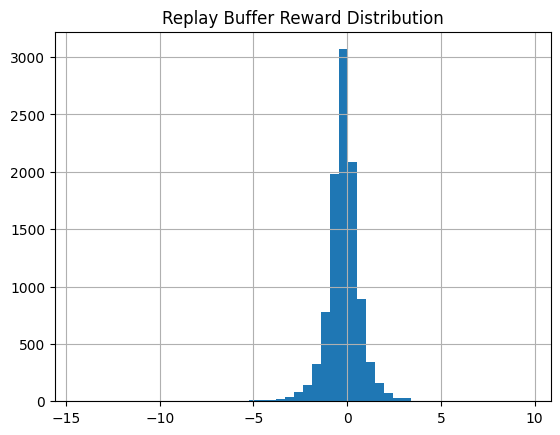

In [36]:
import matplotlib.pyplot as plt
print(f"Reward Min: {min(rewards)}, Reward Max: {max(rewards)}")
print(f"Reward Mean: {np.mean(rewards)}, Reward Std: {np.std(rewards)}")
plt.hist(rewards, bins=50)
plt.title("Replay Buffer Reward Distribution")

plt.grid()

In [ ]:
np.random.uniform(
                -3, 3
            )  # Simulate expected reward range